In [1]:
# Imports
from strategy.actions import random_action
from data.fetch_data import fetch_data
from data.process_data import calculate_returns
from visualizations.plot_results import plot_net_worth, plot_cash, plot_portfolio_value, plot_rewards
from simulations.run_simulation import run_simulation

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
tickers = ['AAPL', 'KO', 'IBM']
start_date = "2010-01-01"
end_date = "2017-12-31"

data = fetch_data(tickers, start_date, end_date)
rets = calculate_returns(data)
data.head()

[*********************100%%**********************]  3 of 3 completed


Ticker,AAPL,IBM,KO
Date,,,
2010-01-01,6.351058,73.703918,17.938570
2010-01-08,6.316373,75.274155,18.238668
2010-01-15,6.275355,73.391022,17.357540
2010-01-22,6.010555,70.404175,17.296883
2010-01-29,5.792197,69.977493,17.057444


In [3]:
np.random.seed(123)

"""
# mapper stores information about each stock in the simulation
- array sof historical returns for respective stock
- used to create randomized price paths by resampling historical returns
"""
mapper = {'AAPL': [rets['AAPL'].values, data['AAPL'].values[0], 0, 75], 
            'KO': [rets['KO'].values, data['KO'].values[0], 0, 75],
            'IBM': [rets['IBM'].values, data['IBM'].values[0], 10, 1150]}

"""
# dictionary to store the price of each stock using the ticker via data. 
- intialized as 0
"""
initial_price_map = {'AAPL': data['AAPL'].values[0], 
            'KO': data['KO'].values[0],
            'IBM': data['IBM'].values[0]}

"""
raw_path stores the simulatd stock price paths through bootstrapping/resampling method (resampleing historical returns) 
- start from an initial price, multiply it by the cumulative product of randomly sampled returns from a historical distribution of returns
- everything is sampled with equal probability, by law of large numbers, the sampled distribution should resemble the original distribution 
path is a filtered version of raw_paths? 
"""

paths = {'AAPL': [], 'KO': [], 'IBM': []}
raw_paths = {'AAPL': [], 'KO': [], 'IBM': []}

for tick in tickers:
    # extract historical returns
    emp_dist = mapper[tick][0]

    for i in range(10000):
        # random sample the returns
        ret_path = np.random.choice(emp_dist, size=len(emp_dist), replace=True)
        # generate price via multiply with cumulative product
        raw_path = mapper[tick][1] * (1 + ret_path).cumprod()
        #add to raw_paths
        raw_paths[tick].append(raw_path)


In [4]:
# Initialize the Q-table

"""
64 - state space (4 discretized spaces)
27 - holding state (current position, -1 short, 0 neutral, 1 long)
27 - action space  (future  position, -1 short, 0 neutral, 1 long)

"""
Q_table = np.zeros((64, 27, 27)) 
Q_table

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [5]:
"""
Categorizes the returns into 4 states, finite number of discrete buckets
"""

def discretize_rets(rets, n_states=4, min_ret=-0.11, max_ret=0.14):
    return np.clip(np.floor((rets - min_ret) / (max_ret - min_ret) * n_states), 0, n_states - 1).astype(int) + 1

In [6]:
"""
These functions aim to map multi-dimensional state representations into a single real (integer) value and vice vera 

map_ret_state_to_real(ret_state): converts the 3D return state into a single integer value
- the return state is a tuple with return state of 3 different stocks (1 - 4)
- 

map_pos_state_to_real(pos_state): convert holding state into an integer 
- pos_state ranges form -1, 0 , 1

map_real_to_pos_state(real_number): convert the integer into holding state 
- decomposes by division/modulus operation

"""

def map_ret_state_to_real(ret_state):
    real = ((ret_state[0] - 1) * 16) + ((ret_state[1] - 1) * 4) + (ret_state[2] - 1)
    return real

def map_pos_state_to_real(pos_state):
    real = ((pos_state[0] - 1) * 9) + ((pos_state[1] - 1) * 3) + (pos_state[2] - 1)
    return real

def map_real_to_pos_state(real_number):
    # Convert the real number to base-3 (get three digits)
    d1 = real_number // 9   # Corresponds to the first die
    d2 = (real_number % 9) // 3   # Corresponds to the second die
    d3 = real_number % 3   # Corresponds to the third die

    # Map base-3 digits (0, 1, 2) back to dice values (1, 2, 3)
    return np.array([d1 + 1, d2 + 1, d3 + 1])


In [7]:
"""
Takes current position of the stocks into the four discrete holding states for the Q-learning framework

Interates through the position array:
if short position (-1), then assign value of 1
if neutral position (0), then value of 2
if long position (1), then value of 3

then returns the discrete holding array

converts to positive indexing because array indices cannot be negative and clarity (- can be ambiguous if data structure doesn't recognize it)
"""
def update_holdings(positions):
    holdings = np.array([2, 2, 2])
    for i, v in enumerate(positions.values()):
            pos = 0
            if v < 0:
                pos = 1
            elif v == 0:
                pos = 2
            else:
                pos = 3
            holdings[i] = pos
    return holdings

"""
self explanatory
"""
def calculate_final_reward(positions, stock_prices):
    final_reward = (positions['AAPL'] * stock_prices['AAPL'].iloc[-1]) + (positions['IBM'] * stock_prices['IBM'].iloc[-1]) + (positions['KO'] * stock_prices['KO'].iloc[-1])
    return final_reward

"""
If the networth is positive, keep evaluating
If networth is negative, then simulator stops

safeguard to not continue trading with negative net worth 
"""
def evaluate_continuation(cash, positions, stock_prices, time):
    port_value = (positions['AAPL'] * stock_prices['AAPL'].iloc[time]) + (positions['IBM'] * stock_prices['IBM'].iloc[time]) + (positions['KO'] * stock_prices['KO'].iloc[time])
    net_worth = cash + port_value
    if net_worth < 0:
        return False
    else:
        return True

In [8]:
"""
Converts list of labeled actions into a structured formaton

input is labeled_actions (-1, 0, 1 for sell, hold, buy)

First sort in alphabetical order
Then extract the first of each item in the array 
Create a list storing only the action where index 0 = KO, index 1 = IBM, index 2 = AAPL
"""

def labeled_actions_to_action_state(labeled_actions):
    sorted_list = sorted(labeled_actions, key=lambda x: x[1])
    legal_action_list = [v[0] for v in sorted_list]
    legal_action = np.array(legal_action_list)
    return legal_action

In [9]:
short_window = 20
long_window = 60

# https://www.cmegroup.com/education/courses/technical-analysis/understanding-moving-averages.html

def detect_regime(prices):
    """Detects market regime using short and long moving averages."""
    short_ma = prices.rolling(window=short_window).mean()
    long_ma = prices.rolling(window=long_window).mean()
    
    regime = np.where(short_ma > long_ma, 1, np.where(short_ma < long_ma, -1, 0))
    
    regime[:max(short_window, long_window)] = 0
    
    return regime

def regime_rewards_adjustment(reward, regime):
    if regime ==1:
        reward *= 1.2
    elif regime == -1:
        reward *= 0.8
    return reward

In [10]:
# Q-learning Algorithm Implementation
n_episodes = 10000  # number of episodes to run 
n_steps = 417 #number of trading perods in each episode
alpha = 0.1 # learning rate
epsilon = 0.1 # exploration rate
gamma = 1 #discount factor 
Q_table = np.zeros((64, 27, 27)) #intiatlize to store q-values later
tickers = ['AAPL', 'KO', 'IBM']


for episode in range(n_episodes):
    cash = 100
    # Use a new stock price series for each episode
    stock_prices = pd.DataFrame({'AAPL': raw_paths['AAPL'][episode], 'IBM': raw_paths['IBM'][episode], 'KO': raw_paths['KO'][episode]})
    stock_returns = stock_prices.pct_change()

    regimes = {ticker: detect_regime(stock_prices[ticker]) for ticker in tickers}

    # Initialize holdings to zero and a random state for the prior return

     # start with no shares
    raw_holdings = {'AAPL': 0, 'IBM': 0, 'KO': 0}
    # initialize transaction 
    transaction_log = {'AAPL': {1: [], 3: []}, 'IBM': {1: [], 3: []}, 'KO': {1: [], 3: []}}
    # intialize holding state
    holdings = np.array([2, 2, 2])
    # random initialize prior return state
    returns = np.random.choice([1, 2, 3, 4], 3)
    # convert prior return state into a integer
    return_state = map_ret_state_to_real(returns)
    # convert the holding state into an integer
    holdings_state = map_pos_state_to_real(holdings)
    # track rewards and contributions
    rewards_list = []
    cumulative_rewards = 0
    
    #iterate over each time step within the episode
    for t in range(n_steps - 1):
        # check if episode should continue based on net worth 
        if not evaluate_continuation(cash, raw_holdings, stock_prices, t):
            break
        # Choose action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            # randomly choose action if exploration
            action = np.random.choice([1, 2, 3], 3)
        else:
            # exploit, choose the maximum value from the 1D aray of all posible action states from that 
            # specific combinaton of return state and holding state
            # return_state and holdings_state at that timestep. 
            action = np.argmax(Q_table[return_state, holdings_state])
            # the highest value means best action. so...map_real_to_pos_state transaltes this info 
            # the combination of actions for the 3 stocks...ex: action = 2, then [3,2,1], so buy KO, hold IBM, sell AAPL
            action = map_real_to_pos_state(action)
        
        # determin next return state based on next period returns
        # take the retunrs at the next time step and categorize into discretized returns
        next_return_state = discretize_rets(stock_returns.iloc[t + 1, :])
        # then convert it into an integer state
        next_return_state = map_ret_state_to_real(next_return_state)

        reward = 0

        # Sort actions so that we evaluate sell orders first in order to fund potential buys
        """
        action = [3, 2, 1]
        tickers = ['AAPL', 'KO', 'IBM']
        
        list = [(3, 'AAPL'), (2, 'KO'), (1, 'IBM')]
        sorted list = in order from 1 to 3
        """
        labeled_actions = []
        for i in zip(action, tickers):
            labeled_actions.append(list(i))
        labeled_actions.sort(key=lambda x: x[0]) # sort by action type (sell, hold, buy)
        
        for i in range(3): #(1,2,3 actions)
            regime = regimes[labeled_actions[i][1]][t]  # Get the current market regime for the stock

            if labeled_actions[i][0] == 3:  # Buy
                if(cash - stock_prices[labeled_actions[i][1]][t] > 0) and (raw_holdings[labeled_actions[i][1]] < 2):  # Can only buy if have enough cash
                    """
                    if there are previous sell price, the reward is the difference between first recorded sell price and the current buy price
                    then the first recorded sell price is removed from transaction log
                    transaction_log = {
                    'AAPL': {1: [], 3: []},   
                    'IBM': {1: [], 3: []},
                    'KO': {1: [], 3: []}

                    labeled_actions[i] could be [3, 'AAPL']
                    transaction_log[labeled_actions[i][1]] => transaction_log['AAPL']
                    transaction_log[labeled_actions[i][1]][1] => list of past sell prices[1] for AAPL 

                    transaction_log['AAPL'][1] is [150, 145] => pop 150 
                    stock_prices[labeled_actions[i][1]][t] => stock_prices['AAPL'][t]
                    """
                    if transaction_log[labeled_actions[i][1]][1]:
                        reward += transaction_log[labeled_actions[i][1]][1][0] - stock_prices[labeled_actions[i][1]][t]
                        transaction_log[labeled_actions[i][1]][1].pop(0)

                    # if no recorded sells, current buy price is logged for future calculations
                    else:
                        transaction_log[labeled_actions[i][1]][3].append(stock_prices[labeled_actions[i][1]][t])

                    # cash reduced by buy price, holding is incremented by one share
                    cash -= stock_prices[labeled_actions[i][1]][t]
                    raw_holdings[labeled_actions[i][1]] += 1

                else: # If not enough cash to buy, then hold
                    labeled_actions[i][0] = 2

            elif labeled_actions[i][0] == 2: # Hold
                pass

            elif labeled_actions[i][0] == 1:  # Sell
                if raw_holdings[labeled_actions[i][1]] < -2: # position limit
                    labeled_actions[i][0] = 2 # changes to hold
                else: 
                    if transaction_log[labeled_actions[i][1]][3]:
                            reward += stock_prices[labeled_actions[i][1]][t] - transaction_log[labeled_actions[i][1]][3][0]
                            transaction_log[labeled_actions[i][1]][3].pop(0)
                    else:
                        transaction_log[labeled_actions[i][1]][1].append(stock_prices[labeled_actions[i][1]][t])

                cash += stock_prices[labeled_actions[i][1]][t]
                raw_holdings[labeled_actions[i][1]] -= 1
                
        reward = regime_rewards_adjustment(reward, regime)

        # converts labeled actions into an array
        action = labeled_actions_to_action_state(labeled_actions)
        # map action into the action_state index
        action_state = map_pos_state_to_real(action)
        #raw holding (current holding ) updated for the new holding
        next_holdings = update_holdings(raw_holdings)
        # new hodling state mapped to unqiue index, moving this to the next time step 
        next_holdings_state = map_pos_state_to_real(next_holdings)
        
        # Q-learning update
        Q_table[return_state, holdings_state, action_state] += alpha * (reward + gamma * np.max(Q_table[next_return_state, next_holdings_state]) - Q_table[return_state, holdings_state, action_state])

        # Proportional distribution of cumulative reward
        cumulative_rewards += reward
        rewards_list.append((return_state, holdings_state, action_state, reward))

        # Transition to next state
        holdings = next_holdings
        holdings_state = next_holdings_state
        return_state = next_return_state

    final_reward = calculate_final_reward(raw_holdings, stock_prices)

    total_cumulative_rewards = cumulative_rewards + final_reward
    for ret_state, hold_state, act_state, step_reward in rewards_list:
        if total_cumulative_rewards != 0:
            proportion = step_reward/total_cumulative_rewards
        else:
            proportion = 0

    Q_table[return_state, holdings_state, action_state] += proportion * final_reward

optimal_policy = np.argmax(Q_table, axis=2)


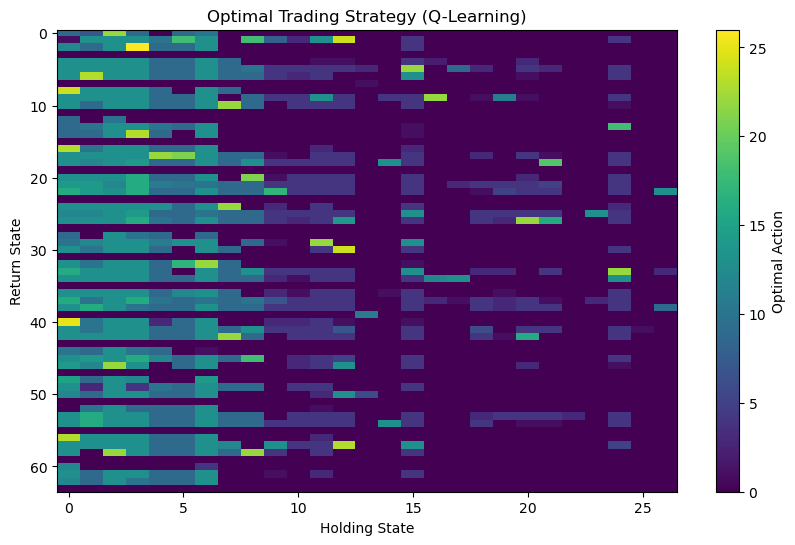

In [11]:
# Visualization of the optimal policy
plt.figure(figsize=(10, 6))
plt.imshow(optimal_policy, cmap="viridis", aspect="auto")
plt.colorbar(label="Optimal Action")
plt.xlabel("Holding State")
plt.ylabel("Return State")
plt.title("Optimal Trading Strategy (Q-Learning)")
plt.show()

# Visualization of the Q-values
# plt.figure(figsize=(10, 6))
# for holding in range(27):
#    for action in range(27):
#        plt.plot(Q_table[:, holding, action], label=f"Action {action} (Holding={holding})")
# plt.xlabel("Stock Price State")
# plt.ylabel("Q-Value")
# plt.title("Q-Values for Different Actions and Holding States")
# plt.legend()
# plt.grid(True)
# plt.show()


In [12]:
optimal_policy

array([[ 9,  7, 22, ...,  0,  0,  0],
       [ 1, 13, 13, ...,  4,  0,  0],
       [12,  9, 13, ...,  0,  0,  0],
       ...,
       [13,  9, 13, ...,  0,  0,  0],
       [12,  9, 13, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int64)

In [13]:
Q_table[1, 0, :]

array([2.79934379e+01, 3.69152475e+02, 4.32429771e+01, 3.67390321e+02,
       2.78238321e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.00985112e+01, 2.68778170e+02, 1.84979196e+01,
       3.19170978e+02, 1.87245216e+02, 6.46114604e+01, 2.04459522e+01,
       1.89445717e+01, 4.10502464e+01, 4.10744113e+00, 0.00000000e+00,
       0.00000000e+00, 1.84419059e+01, 1.88381845e-01, 3.52842632e+01,
       5.11578338e+00, 3.91267828e+01, 0.00000000e+00])

## Evaluate Policy

In [14]:
tickers = ['AAPL', 'KO', 'IBM']
start_date = "2009-12-28"
end_date = "2018-12-31"

test_data_prices = fetch_data(tickers, start_date, end_date)
test_data_rets = test_data_prices.pct_change()

test_data_prices = test_data_prices.iloc[1:, :]
test_data_rets = test_data_rets.iloc[1:, :]
test_data_rets.head(5)

[*********************100%%**********************]  3 of 3 completed


Ticker,AAPL,IBM,KO
Date,,,
2010-01-04,0.005932,-0.000382,-0.032456
2010-01-11,-0.028540,0.007107,0.020671
2010-01-18,-0.039722,-0.047655,-0.036419
2010-01-25,-0.028774,-0.024781,0.000184
2010-02-01,0.017703,0.009233,-0.021383


In [15]:
tracker = {}
cash = 100
holdings = np.array([2, 2, 2])
tickers = ['AAPL', 'IBM', 'KO']
raw_holdings = {'AAPL': 0, 'IBM': 0, 'KO': 0} 

for t in range(len(test_data_prices)):
    if not evaluate_continuation(cash, raw_holdings, test_data_prices, t):
            break
    
    prior_returns = discretize_rets(test_data_rets.iloc[t, :])
    return_state = map_ret_state_to_real(prior_returns)
    holdings_state = map_pos_state_to_real(holdings)
   # print('Time (t):', t)
   # print('Holdings State:', holdings_state)
   # print('Return State:', return_state)

    action = map_real_to_pos_state(optimal_policy[return_state][holdings_state])

    # Sort actions so that we evaluate sell orders first in order to fund potential buys
    labeled_actions = []
    for i in zip(action, tickers):
        labeled_actions.append(list(i))
    labeled_actions.sort(key=lambda x: x[0])
        
    for i in range(3):
        if labeled_actions[i][0] == 3:  # Buy
            if cash - test_data_prices[labeled_actions[i][1]][t] > 0:  # Can only buy if have enough cash
                cash -= test_data_prices[labeled_actions[i][1]][t]
                raw_holdings[labeled_actions[i][1]] += 1

            else: # If not enough cash to buy, then hold
                labeled_actions[i][0] = 2

        elif labeled_actions[i][0] == 2: # Hold
            pass

        elif labeled_actions[i][0] == 1:  # Sell
            cash += test_data_prices[labeled_actions[i][1]][t]
            raw_holdings[labeled_actions[i][1]] -= 1
    
    port_value = (raw_holdings['AAPL'] * test_data_prices['AAPL'].iloc[t]) + (raw_holdings['IBM'] * test_data_prices['IBM'].iloc[t]) + (raw_holdings['KO'] * test_data_prices['KO'].iloc[t])
    net_worth = cash + port_value
    tracker[t] = (cash, port_value, net_worth, action)
    holdings = update_holdings(raw_holdings)


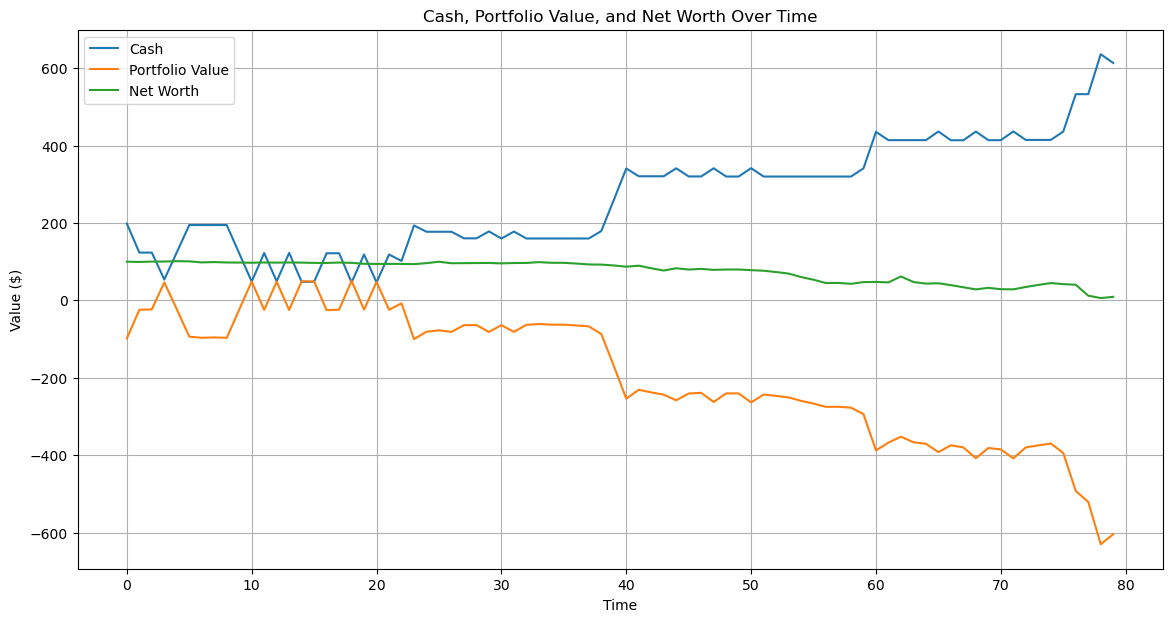

,Cash,Portfolio Value,Net Worth,Action
0,198.443365,-98.443365,100.000000,"[1, 1, 1]"
1,123.470739,-24.181318,99.289421,"[2, 3, 2]"
2,123.470739,-23.280147,100.190593,"[2, 2, 2]"
3,53.840292,46.518718,100.359010,"[2, 3, 2]"
4,124.113615,-22.843940,101.269675,"[2, 1, 2]"
...,...,...,...,...
75,436.279860,-394.255573,42.024286,"[2, 2, 1]"
76,532.797369,-492.430209,40.367160,"[2, 1, 2]"
77,532.797369,-520.626061,12.171308,"[2, 2, 2]"
78,635.992186,-630.017692,5.974494,"[2, 1, 2]"


In [16]:
# Convert tracker dictionary to DataFrame
tracker_df = pd.DataFrame.from_dict(tracker, orient='index', columns=['Cash', 'Portfolio Value', 'Net Worth', 'Action'])

# Plot Cash, Portfolio Value, and Net Worth over time
plt.figure(figsize=(14, 7))
plt.plot(tracker_df.index, tracker_df['Cash'], label='Cash')
plt.plot(tracker_df.index, tracker_df['Portfolio Value'], label='Portfolio Value')
plt.plot(tracker_df.index, tracker_df['Net Worth'], label='Net Worth')
plt.xlabel('Time')
plt.ylabel('Value ($)')
plt.title('Cash, Portfolio Value, and Net Worth Over Time')
plt.legend()
plt.grid(True)
plt.show()


tracker_df

In [17]:
# convert tracker to weekly, monthly and yearly 

start_date = pd.to_datetime("2010-01-01")   
date_range = pd.date_range(start=start_date, periods=len(tracker_df), freq='5B')  # 'B' represents business days
tracker_df.index = date_range

# extract year
tracker_df['Year'] = tracker_df.index.year
tracker_df['Month'] = tracker_df.index.month


In [18]:
tracker_df

,Cash,Portfolio Value,Net Worth,Action,Year,Month
2010-01-01,198.443365,-98.443365,100.000000,"[1, 1, 1]",2010,1
2010-01-08,123.470739,-24.181318,99.289421,"[2, 3, 2]",2010,1
2010-01-15,123.470739,-23.280147,100.190593,"[2, 2, 2]",2010,1
2010-01-22,53.840292,46.518718,100.359010,"[2, 3, 2]",2010,1
2010-01-29,124.113615,-22.843940,101.269675,"[2, 1, 2]",2010,1
...,...,...,...,...,...,...
2011-06-10,436.279860,-394.255573,42.024286,"[2, 2, 1]",2011,6
2011-06-17,532.797369,-492.430209,40.367160,"[2, 1, 2]",2011,6
2011-06-24,532.797369,-520.626061,12.171308,"[2, 2, 2]",2011,6
2011-07-01,635.992186,-630.017692,5.974494,"[2, 1, 2]",2011,7


In [23]:

# Assuming 'df' is your existing dataframe
# Ensure 'Date' is in datetime format
tracker_df['Date'] = pd.to_datetime(tracker_df.index)

# Extract Year and Month from 'Date'
tracker_df['Year'] = tracker_df['Date'].dt.year
tracker_df['Month'] = tracker_df['Date'].dt.month

# Group by Year and Month, and calculate the monthly change in Net Worth
monthly_changes = tracker_df.groupby(['Year', 'Month']).agg({
    'Net Worth': lambda x: x.iloc[-1] - x.iloc[0]  # Calculate the change
}).reset_index()

# Rename the column to indicate the change in Net Worth
monthly_changes.rename(columns={'Net Worth': 'Net Worth Change'}, inplace=True)

# Display the resulting dataframe
monthly_changes


,Year,Month,Net Worth Change
0,2010,1,1.269670
1,2010,2,1.382869
2,2010,3,-0.872478
3,2010,4,0.933955
4,2010,5,0.521297
...,...,...,...
103,2018,8,-28.739536
104,2018,9,-2.280033
105,2018,10,275.063740
106,2018,11,33.065712


In [30]:
monthly_changes.to_pickle('monthly_changes.pkl')

In [35]:
tracker_df.to_pickle('tracker_df.pkl')